In [15]:
import pandas as pd
import numpy as np
from pycaret.regression import *
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
sp500_path = '../data/sandp500/individual_stocks_5yr/individual_stocks_5yr/AAPL_data.csv'
sp500 = pd.read_csv(sp500_path)
print(sp500.shape)
sp500.head()

(1259, 7)


,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


## Moving Average

In [3]:
sp500['ma10_close'] = sp500['close'].rolling(10).mean()
sp500['ma10_open'] = sp500['open'].rolling(10).mean()

sp500['ma50_close'] = sp500['close'].rolling(50).mean()
sp500['ma50_open'] = sp500['open'].rolling(50).mean()

## Moving Average Convergence Divergence (MACD)
- https://towardsdatascience.com/implementing-macd-in-python-cc9b2280126a

In [4]:
exp1 = sp500.close.ewm(span=12, adjust=False).mean()
exp2 = sp500.close.ewm(span=26, adjust=False).mean()

macd = exp1-exp2
exp3 = macd.ewm(span=9, adjust=False).mean()

In [5]:
sp500['macd'] = macd
sp500['exp3'] = exp3

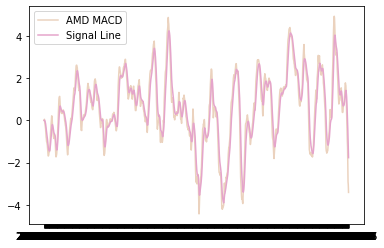

In [6]:
plt.plot(sp500.date, macd, label='AMD MACD', color = '#EBD2BE')
plt.plot(sp500.date, exp3, label='Signal Line', color='#E5A4CB')
plt.legend(loc='upper left')
plt.show()

## On-Balance Volume (OBV)
- https://randerson112358.medium.com/stock-trading-strategy-using-on-balance-volume-obv-python-77a7c719cdac

In [7]:
#Calculate the On Balance Volume
OBV = []
OBV.append(0)
for i in range(1, len(sp500.close)):
    if sp500.close[i] > sp500.close[i-1]: #If the closing price is above the prior close price 
          OBV.append(OBV[-1] + sp500.volume[i]) #then: Current OBV = Previous OBV + Current Volume
    elif sp500.close[i] < sp500.close[i-1]:
          OBV.append( OBV[-1] - sp500.volume[i])
    else:
          OBV.append(OBV[-1])

In [8]:
#Store the OBV and OBV EMA into new columns
sp500['OBV'] = OBV
sp500['OBV_EMA'] = sp500['OBV'].ewm(com=20).mean()
#Show the data
sp500.head()

,date,open,high,low,close,volume,Name,ma10_close,ma10_open,ma50_close,ma50_open,macd,exp3,OBV,OBV_EMA
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL,NaN,NaN,NaN,NaN,0.000000,0.000000,0,0.000000e+00
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL,NaN,NaN,NaN,NaN,0.056415,0.011283,129029425,6.608824e+07
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL,NaN,NaN,NaN,NaN,-0.037125,0.001601,-22799938,3.500205e+07
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL,NaN,NaN,NaN,NaN,-0.120135,-0.022746,-141521933,-1.240924e+07
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL,NaN,NaN,NaN,NaN,-0.188588,-0.055914,-230331087,-6.034681e+07


In [9]:
#Create a function to signal when to buy and sell an asset
#If OBV > OBV_EMA Then Buy
#If OBV < OBV_EMA Then Sell
#Else Do nothing
def buy_sell(signal, col1, col2):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1 #A flag for the trend upward/downward
  #Loop through the length of the data set
  for i in range(0,len(signal)):
    #if OBV > OBV_EMA  and flag != 1 then buy else sell
      if signal[col1][i] > signal[col2][i] and flag != 1:
          sigPriceBuy.append(signal['close'][i])
          sigPriceSell.append(np.nan)
          flag = 1
      #else  if OBV < OBV_EMA  and flag != 0 then sell else buy
      elif signal[col1][i] < signal[col2][i] and flag != 0:    
          sigPriceSell.append(signal['close'][i])
          sigPriceBuy.append(np.nan)
          flag = 0
      #else   OBV == OBV_EMA  so append NaN 
      else: 
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)

In [10]:
#Create buy and sell columns
x = buy_sell(sp500, 'OBV','OBV_EMA' )
sp500['Buy_Signal_Price'] = x[0]
sp500['Sell_Signal_Price'] = x[1]
#Show the data frame
sp500.head()

,date,open,high,low,close,volume,Name,ma10_close,ma10_open,ma50_close,ma50_open,macd,exp3,OBV,OBV_EMA,Buy_Signal_Price,Sell_Signal_Price
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL,NaN,NaN,NaN,NaN,0.000000,0.000000,0,0.000000e+00,NaN,NaN
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL,NaN,NaN,NaN,NaN,0.056415,0.011283,129029425,6.608824e+07,68.5614,NaN
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL,NaN,NaN,NaN,NaN,-0.037125,0.001601,-22799938,3.500205e+07,NaN,66.8428
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL,NaN,NaN,NaN,NaN,-0.120135,-0.022746,-141521933,-1.240924e+07,NaN,NaN
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL,NaN,NaN,NaN,NaN,-0.188588,-0.055914,-230331087,-6.034681e+07,NaN,NaN


## Relative Strength Index (RSI)
- https://www.learnpythonwithrune.org/pandas-calculate-the-relative-strength-index-rsi-on-a-stock/
- https://levelup.gitconnected.com/trading-using-python-relative-strength-index-rsi-f0c63c1c0db
- The Relative Strength Index (RSI) is a popular momentum oscillator developed in 1978.
- RSI provides an indication if the asset is overbought or undersold. It usually is displayed below the SMA/EMA graphs.
- An asset is usually considered overbought when the RSI is above 70% and undersold when it is below 30%.
- RSI is usually calculated over 14 intervals (mostly days) and you will see it represented as RSI14

In [11]:
delta = sp500['close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
sp500['rs'] = ema_up/ema_down
sp500['RSI'] = 100 - (100/(1 + sp500['rs']))

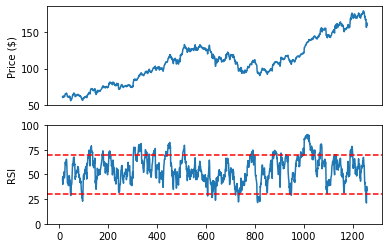

In [12]:
# Skip first 14 days to have real values
ticker = sp500.iloc[14:]

# print(ticker)
fig, (ax1, ax2) = plt.subplots(2)
ax1.get_xaxis().set_visible(False)

ticker['close'].plot(ax=ax1)
ax1.set_ylabel('Price ($)')
ticker['RSI'].plot(ax=ax2)
ax2.set_ylim(0,100)
ax2.axhline(30, color='r', linestyle='--')
ax2.axhline(70, color='r', linestyle='--')
ax2.set_ylabel('RSI')

plt.show()

## Train models
- https://github.com/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Intermediate%20-%20REG102.ipynb

In [16]:
drop_cols = [
    'Name',
]

In [13]:
sp500.head()

,date,open,high,low,close,volume,Name,ma10_close,ma10_open,ma50_close,ma50_open,macd,exp3,OBV,OBV_EMA,Buy_Signal_Price,Sell_Signal_Price,rs,RSI
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL,NaN,NaN,NaN,NaN,0.000000,0.000000,0,0.000000e+00,NaN,NaN,NaN,NaN
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL,NaN,NaN,NaN,NaN,0.056415,0.011283,129029425,6.608824e+07,68.5614,NaN,-inf,100.000000
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL,NaN,NaN,NaN,NaN,-0.037125,0.001601,-22799938,3.500205e+07,NaN,66.8428,5.349470,84.250655
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL,NaN,NaN,NaN,NaN,-0.120135,-0.022746,-141521933,-1.240924e+07,NaN,NaN,4.954557,83.206140
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL,NaN,NaN,NaN,NaN,-0.188588,-0.055914,-230331087,-6.034681e+07,NaN,NaN,4.775473,82.685402


In [17]:
# split two training and testing dataset
train, test = train_test_split(sp500, test_size=0.2)

### Set up environment in PyCaret

In [18]:
exp_reg101 = setup(
    data = train.drop(drop_cols, axis=1),
    target = 'close',
    feature_interaction = True,
    feature_ratio = True
)

,Description,Value
0,session_id,5074
1,Target,close
2,Original Data,"(1007, 18)"
3,Missing Values,True
4,Numeric Features,16
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(704, 51)"


### Model comparison

In [20]:
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.5803,0.6594,0.7940,0.9992,0.0071,0.0054,0.0050
en,Elastic Net,0.6429,0.8414,0.8947,0.9990,0.0089,0.0063,0.0070
et,Extra Trees Regressor,0.6248,0.8775,0.9143,0.9990,0.0088,0.0059,0.0720
lasso,Lasso Regression,0.6891,0.9116,0.9367,0.9990,0.0093,0.0068,0.3150
gbr,Gradient Boosting Regressor,0.6849,0.9399,0.9506,0.9989,0.0084,0.0063,0.0630
lightgbm,Light Gradient Boosting Machine,0.6921,0.9921,0.9738,0.9989,0.0086,0.0064,0.3450
br,Bayesian Ridge,0.5981,0.9708,0.9130,0.9989,0.0093,0.0058,0.0060
rf,Random Forest Regressor,0.6932,1.0699,1.0077,0.9988,0.0095,0.0065,0.0980
catboost,CatBoost Regressor,0.7106,1.4933,1.1619,0.9983,0.0114,0.0069,2.7510
xgboost,Extreme Gradient Boosting,0.8707,1.5946,1.2398,0.9982,0.0110,0.0081,0.1600


In [21]:
top3

[OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                           normalize=True, precompute='auto', tol=None),
 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=5074, selection='cyclic', tol=0.0001, warm_start=False),
 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=5074, verbose=0, warm_start=False)]

### Create models

In [22]:
omp_model = create_model('omp')
en_model = create_model('en')
et_model = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7082,1.2269,1.1076,0.9985,0.0116,0.0066
1,0.6256,0.7182,0.8475,0.9990,0.0071,0.0055
2,0.7022,1.4412,1.2005,0.9984,0.0096,0.0063
3,0.7319,1.5365,1.2395,0.9985,0.0137,0.0076
4,0.5720,0.5580,0.7470,0.9994,0.0067,0.0052
5,0.5454,0.5843,0.7644,0.9994,0.0070,0.0050
6,0.5567,0.6166,0.7853,0.9995,0.0079,0.0054
7,0.5476,0.5055,0.7110,0.9993,0.0064,0.0050
8,0.7606,1.1276,1.0619,0.9985,0.0099,0.0071
9,0.4974,0.4602,0.6784,0.9995,0.0078,0.0053


In [23]:
omp_tune_model = tune_model(omp_model)
en_tune_model = tune_model(en_model)
et_tune_model = tune_model(et_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.9688,2.9136,1.7069,0.9965,0.0199,0.0095
1,0.7411,0.8890,0.9429,0.9988,0.0084,0.0067
2,0.7261,1.1857,1.0889,0.9986,0.0097,0.0068
3,0.9621,2.3128,1.5208,0.9978,0.0165,0.0098
4,0.8166,1.1447,1.0699,0.9987,0.0098,0.0074
5,0.7600,1.0230,1.0114,0.9989,0.0096,0.0072
6,0.8338,1.7482,1.3222,0.9985,0.0115,0.0075
7,0.7189,0.9570,0.9783,0.9987,0.0088,0.0064
8,0.9390,1.6451,1.2826,0.9978,0.0125,0.0091
9,0.7698,1.4324,1.1968,0.9985,0.0145,0.0085


In [24]:
omp_tune_model2 = tune_model(omp_model, n_iter = 50)
en_tune_model2 = tune_model(en_model, n_iter = 50)
et_tune_model2 = tune_model(et_model, n_iter = 50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7592,1.5897,1.2608,0.9981,0.0142,0.0073
1,0.6331,0.7266,0.8524,0.9990,0.0073,0.0056
2,0.7080,1.2891,1.1354,0.9985,0.0094,0.0065
3,0.8384,2.4966,1.5800,0.9976,0.0182,0.0088
4,0.5708,0.5352,0.7316,0.9994,0.0065,0.0052
5,0.5681,0.5899,0.7681,0.9994,0.0070,0.0052
6,0.6845,0.9365,0.9677,0.9992,0.0091,0.0064
7,0.5720,0.5418,0.7361,0.9993,0.0065,0.0052
8,0.7571,1.1853,1.0887,0.9984,0.0103,0.0072
9,0.5445,0.7605,0.8721,0.9992,0.0110,0.0060


In [25]:
plot_model(omp_tune_model, plot = 'parameter')

,Parameters
fit_intercept,True
n_nonzero_coefs,40
normalize,True
precompute,auto
tol,None


In [26]:
plot_model(omp_tune_model2, plot = 'parameter')

,Parameters
fit_intercept,True
n_nonzero_coefs,36
normalize,True
precompute,auto
tol,None


In [27]:
xgboost = create_model('xgboost')
stacker2 = stack_models(top3, meta_model = xgboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.1017,2.3609,1.5365,0.9972,0.0130,0.0098
1,0.8819,1.2749,1.1291,0.9983,0.0105,0.0082
2,0.9521,2.8038,1.6744,0.9968,0.0131,0.0086
3,0.8430,1.6694,1.2921,0.9984,0.0110,0.0081
4,0.8885,1.2524,1.1191,0.9986,0.0098,0.0079
5,0.8410,1.1456,1.0703,0.9988,0.0096,0.0076
6,0.9309,1.4626,1.2094,0.9988,0.0109,0.0086
7,0.8500,1.2653,1.1249,0.9983,0.0099,0.0078
8,1.0252,2.0831,1.4433,0.9972,0.0139,0.0097
9,0.7949,1.3942,1.1808,0.9986,0.0127,0.0084


In [29]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.5803,0.6594,0.7940,0.9992,0.0071,0.0054,0.0060
en,Elastic Net,0.6429,0.8414,0.8947,0.9990,0.0089,0.0063,0.0070
et,Extra Trees Regressor,0.6248,0.8775,0.9143,0.9990,0.0088,0.0059,0.0790
lasso,Lasso Regression,0.6891,0.9116,0.9367,0.9990,0.0093,0.0068,0.0070
gbr,Gradient Boosting Regressor,0.6849,0.9399,0.9506,0.9989,0.0084,0.0063,0.0620
lightgbm,Light Gradient Boosting Machine,0.6921,0.9921,0.9738,0.9989,0.0086,0.0064,0.1290
br,Bayesian Ridge,0.5981,0.9708,0.9130,0.9989,0.0093,0.0058,0.0060
rf,Random Forest Regressor,0.6932,1.0699,1.0077,0.9988,0.0095,0.0065,0.0980
catboost,CatBoost Regressor,0.7106,1.4933,1.1619,0.9983,0.0114,0.0069,2.7630
xgboost,Extreme Gradient Boosting,0.8707,1.5946,1.2398,0.9982,0.0110,0.0081,0.2100


### Prediction

In [30]:
pred  = predict_model(best, data=test)

In [32]:
pred[['date', 'close', 'Label']]

,date,close,Label
595,2015-06-22,127.6100,128.163018
1114,2017-07-13,147.7700,146.931967
440,2014-11-06,108.7000,108.614784
998,2017-01-26,121.9400,122.651712
395,2014-09-04,98.1200,98.659886
...,...,...,...
927,2016-10-13,116.9800,116.650249
919,2016-10-03,112.5200,112.912322
502,2015-02-06,118.9300,119.227751
97,2013-06-28,56.6471,56.231895


### Model performance

In [34]:
model_performance = pull()
model_performance

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.5803,6.594000e-01,0.7940,9.992000e-01,0.0071,0.0054,0.006
en,Elastic Net,0.6429,8.414000e-01,0.8947,9.990000e-01,0.0089,0.0063,0.007
et,Extra Trees Regressor,0.6248,8.775000e-01,0.9143,9.990000e-01,0.0088,0.0059,0.079
lasso,Lasso Regression,0.6891,9.116000e-01,0.9367,9.990000e-01,0.0093,0.0068,0.007
gbr,Gradient Boosting Regressor,0.6849,9.399000e-01,0.9506,9.989000e-01,0.0084,0.0063,0.062
lightgbm,Light Gradient Boosting Machine,0.6921,9.921000e-01,0.9738,9.989000e-01,0.0086,0.0064,0.129
br,Bayesian Ridge,0.5981,9.708000e-01,0.9130,9.989000e-01,0.0093,0.0058,0.006
rf,Random Forest Regressor,0.6932,1.069900e+00,1.0077,9.988000e-01,0.0095,0.0065,0.098
catboost,CatBoost Regressor,0.7106,1.493300e+00,1.1619,9.983000e-01,0.0114,0.0069,2.763
xgboost,Extreme Gradient Boosting,0.8707,1.594600e+00,1.2398,9.982000e-01,0.0110,0.0081,0.210
